# Unsupervised image denoising

## Import libraries

In [1692]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision.transforms import Compose, ToTensor, ToPILImage, Resize, Lambda, Normalize, Grayscale
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm.notebook import tqdm
import os

## Load data

In [1693]:
directory_data  = './'
filename_data   = 'assignment_08_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

train       = data['x_train'] 
train_noise = data['x_train_noise']

test        = data['x_test'] 
test_noise  = data['x_test_noise']

num_train   = train.shape[0]
num_test    = test.shape[0]

In [1694]:
print('*************************************************')
print('size of train :', train.shape)
print('size of train_noise :', train_noise.shape)
print('*************************************************')
print('size of test :', test.shape)
print('size of test_noise :', test_noise.shape)
print('*************************************************')

*************************************************
size of train : (10000, 32, 32)
size of train_noise : (10000, 32, 32)
*************************************************
size of test : (5000, 32, 32)
size of test_noise : (5000, 32, 32)
*************************************************


## plot examples of the data

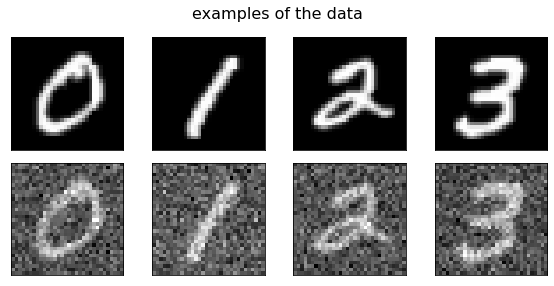

In [1695]:
nRow = 2
nCol = 4
size = 2

title       = 'examples of the data'
fig, axes   = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
fig.suptitle(title, fontsize=16)

for c in range(nCol):

    axes[0, c].imshow(train[c * 1000], cmap='gray')
    axes[1, c].imshow(train_noise[c * 1000], cmap='gray')

    axes[0, c].xaxis.set_visible(False)
    axes[1, c].xaxis.set_visible(False)
    
    axes[0, c].yaxis.set_visible(False)
    axes[1, c].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## custom data loader for the PyTorch framework

In [1696]:
class dataset(Dataset):
    
    def __init__(self, image, image_noise):
        
        self.image          = image
        self.image_noise    = image_noise
    
    def __getitem__(self, index):
        
        image       = self.image[index]
        image_noise = self.image_noise[index]

        image       = torch.FloatTensor(image).unsqueeze(dim=0)
        image_noise = torch.FloatTensor(image_noise).unsqueeze(dim=0)

        return (image, image_noise)
    
    def __len__(self):

        number_image = self.image.shape[0]

        return number_image

## setting device

In [1697]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [1698]:
print(device)

cpu


## construct datasets and dataloaders for testing and testing

In [1699]:
# ================================================== 
# determine your own parameter value
#
size_minibatch      = 25
#
# ================================================== 

dataset_train       = dataset(train, train_noise)
dataset_test        = dataset(test, test_noise)

dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True, drop_last=True)

## shape of the data when using the data loader

In [1700]:
train_image, train_image_noise = next(iter(dataloader_train))
test_image, test_image_noise = next(iter(dataloader_test))

In [1701]:
print('************************************************************')
print('size of mini-batch of the training image:', train_image.shape)
print('************************************************************')
print('size of mini-batch of the training image_noise:', train_image_noise.shape)
print('************************************************************')
print('size of mini-batch of the testing image:', test_image.shape)
print('************************************************************')
print('size of mini-batch of the testing image_noise:', test_image_noise.shape)
print('************************************************************')

************************************************************
size of mini-batch of the training image: torch.Size([25, 1, 32, 32])
************************************************************
size of mini-batch of the training image_noise: torch.Size([25, 1, 32, 32])
************************************************************
size of mini-batch of the testing image: torch.Size([25, 1, 32, 32])
************************************************************
size of mini-batch of the testing image_noise: torch.Size([25, 1, 32, 32])
************************************************************


## construct a neural network 

In [1702]:
# ================================================== 
# define your own neural network architecture and initialization
#
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),  
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(2),
        )
        
        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.MaxPool2d(2,2),
            nn.ReLU(),
            nn.BatchNorm2d(4),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        self.decoder_layer2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(2),
        )
        
        self.decoder_layer1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid(),
        )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------
        self.network = nn.Sequential(
            self.encoder_layer1,
            self.encoder_layer2,
            self.decoder_layer2, 
            self.decoder_layer1,
        )
        
        self.initialize_weight()

    def forward(self,x):
    
        out = self.network(x)
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass
#
# ================================================== 

## build the network

In [1703]:
# ================================================== 
# determine your own parameter value
#
learning_rate   = 0.00001
weight_decay    = 0.0
alpha           = 0.001
number_epoch    = 200
#
# ================================================== 

model       = Network().to(device)
optimizer   = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## compute the prediction

In [1704]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

## compute the data fidelity term
- use the mean squared error for the data fidelity term
- use the following loss function `nn.MSELoss()`
- input dimension: mini-batch-size x channel x height x width

In [1705]:
def compute_loss_data_fidelity(prediction, original):
    # ================================================== 
    # fill up the blank
    #    
    loss = nn.MSELoss()(prediction, original)
    #
    # ================================================== 

    return loss

## compute the regularization term
- use the total variation for the regularization term
- use the following loss function: $\frac{1}{n} \sum_{x, y} \lvert \frac{\partial}{\partial x} f(x, y) \rvert + \frac{1}{n} \sum_{x, y} \lvert \frac{\partial}{\partial y} f(x, y) \rvert$
- use the neumann boundary condition (gradient of the boundary to the normal direction is zero)

In [1706]:
def compute_loss_regularization(prediction):
    # ================================================== 
    # fill up the blank
    #
    num_data = (prediction.shape[0]-1)*prediction.shape[2]*prediction.shape[3]
    #zero_x_column = np.zeros((prediction.shape[0],1))  
    #zero_y_column = np.zeros((1,prediction.shape[1])) 

    x_diff_array = torch.abs(torch.diff(prediction, axis=0))
    y_diff_array = torch.abs(torch.diff(prediction, axis=1))

    #x_diff_boundary = np.hstack([x_diff_array,zero_x_column])
    # y_diff_boundary = np.vstack([y_diff_array, zero_y_column])
    loss = (torch.sum(x_diff_array) + torch.sum(y_diff_array)) / num_data
    #
    # ================================================== 
    return loss

## compute the total loss
- total loss = data fidelity + $\alpha$ * regularization
- $\alpha \in \mathbb{R}$

In [1707]:
def compute_loss(prediction, original, alpha):
    # ================================================== 
    # fill up the blank
    #    
    loss_data_fidelity  = compute_loss_data_fidelity(prediction, original)
    loss_regularization = compute_loss_regularization(prediction)

    loss = loss_data_fidelity + alpha * loss_regularization
    #
    # ================================================== 

    return (loss, loss_data_fidelity, loss_regularization)

## compute the loss value

In [1708]:
def compute_loss_value(loss):
    
    loss_value = loss.item()
    
    return loss_value

## compute the PSNR metric

- input dimension: mini-batch-size x channel x height x width
- psnr is defined by $10 * \log_{10}(\frac{1}{\textrm{MSE}})$
- MSE is defined by $\textrm{MSE}(x, y) = \frac{1}{n} \| x - y \|_2^2$ where $n$ is the length of data $x$ and $y$

In [1709]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [1710]:
loss_train_mean = np.zeros(number_epoch)
loss_train_std  = np.zeros(number_epoch)
psnr_train_mean = np.zeros(number_epoch)
psnr_train_std  = np.zeros(number_epoch)

loss_test_mean  = np.zeros(number_epoch)
loss_test_std   = np.zeros(number_epoch)
psnr_test_mean  = np.zeros(number_epoch)
psnr_test_std   = np.zeros(number_epoch)

loss_train_data_fidelity_mean   = np.zeros(number_epoch)
loss_train_data_fidelity_std    = np.zeros(number_epoch)
loss_train_regularization_mean  = np.zeros(number_epoch)
loss_train_regularization_std   = np.zeros(number_epoch)

loss_test_data_fidelity_mean    = np.zeros(number_epoch)
loss_test_data_fidelity_std     = np.zeros(number_epoch)
loss_test_regularization_mean   = np.zeros(number_epoch)
loss_test_regularization_std    = np.zeros(number_epoch)

## train

In [1711]:
def train(model, optimizer, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    psnr_epoch                  = []

    model.train()

    for index_batch, (image, image_noise) in enumerate(dataloader):

        image       = image.to(device)
        image_noise = image_noise.to(device)

        # ================================================== 
        # fill up the blank
        # def compute_loss(prediction, original, alpha) 
        # 
        optimizer.zero_grad()            
        prediction = compute_prediction(model, image_noise)
        loss_value                  = compute_loss(prediction, image_noise, alpha)[0]
        loss                        = compute_loss_value(loss_value)
        loss_data_fidelity_value    = compute_loss_value(compute_loss(prediction, image_noise, alpha)[1])
        loss_regularization_value   = compute_loss_value(compute_loss(prediction, image_noise, alpha)[2])
        psnr                        = compute_psnr(prediction, image)
        #
        # ================================================== 
    
        loss_epoch.append(loss)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

        # ================================================== 
        # fill up the blank (update moodel parameters)
        #        
        loss_value.backward()
        optimizer.step()
        #
        # ==================================================  

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    psnr_mean   = np.mean(psnr_epoch)
    psnr_std    = np.std(psnr_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    psnr                = {'mean' : psnr_mean, 'std' : psnr_std}

    return (loss, loss_data_fidelity, loss_regularization, psnr)

## test

In [1712]:
def test(model, dataloader):

    loss_epoch                  = []
    loss_data_fidelity_epoch    = []
    loss_regularization_epoch   = []
    psnr_epoch                  = []

    model.eval()

    for index_batch, (image, image_noise) in enumerate(dataloader):
    
        image       = image.to(device)
        image_noise = image_noise.to(device)

        # ================================================== 
        # fill up the blank
        #               
        prediction = compute_prediction(model, image_noise)
        loss_value                  = compute_loss_value(compute_loss(prediction, image_noise, alpha)[0])
        loss_data_fidelity_value    = compute_loss_value(compute_loss(prediction, image_noise, alpha)[1])
        loss_regularization_value   = compute_loss_value(compute_loss(prediction, image_noise, alpha)[2])
        psnr                        = compute_psnr(prediction, image)
        #
        # ================================================== 

        loss_epoch.append(loss_value)
        loss_data_fidelity_epoch.append(loss_data_fidelity_value)
        loss_regularization_epoch.append(loss_regularization_value)
        psnr_epoch.append(psnr)

    loss_mean   = np.mean(loss_epoch)
    loss_std    = np.std(loss_epoch)

    loss_data_fidelity_mean = np.mean(loss_data_fidelity_epoch)
    loss_data_fidelity_std  = np.std(loss_data_fidelity_epoch)

    loss_regularization_mean    = np.mean(loss_regularization_epoch)
    loss_regularization_std     = np.std(loss_regularization_epoch)
    
    psnr_mean   = np.mean(psnr_epoch)
    psnr_std    = np.std(psnr_epoch)

    loss                = {'mean' : loss_mean, 'std' : loss_std}
    loss_data_fidelity  = {'mean' : loss_data_fidelity_mean, 'std' : loss_data_fidelity_std}
    loss_regularization = {'mean' : loss_regularization_mean, 'std' : loss_regularization_std}
    psnr                = {'mean' : psnr_mean, 'std' : psnr_std}

    return (loss, loss_data_fidelity, loss_regularization, psnr)

## train and test

In [1713]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, loss_data_fidelity_train, loss_regularization_train, psnr_train) = train(model, optimizer, dataloader_train)

    loss_train_mean[i]  = loss_train['mean']
    loss_train_std[i]   = loss_train['std']

    loss_train_data_fidelity_mean[i]    = loss_data_fidelity_train['mean']
    loss_train_data_fidelity_std[i]     = loss_data_fidelity_train['std']

    loss_train_regularization_mean[i]   = loss_regularization_train['mean']
    loss_train_regularization_std[i]    = loss_regularization_train['std']

    psnr_train_mean[i]  = psnr_train['mean']
    psnr_train_std[i]   = psnr_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, loss_data_fidelity_test, loss_regularization_test, psnr_test) = test(model, dataloader_test)

    loss_test_mean[i]  = loss_test['mean']
    loss_test_std[i]   = loss_test['std']

    loss_test_data_fidelity_mean[i]    = loss_data_fidelity_test['mean']
    loss_test_data_fidelity_std[i]     = loss_data_fidelity_test['std']

    loss_test_regularization_mean[i]   = loss_regularization_test['mean']
    loss_test_regularization_std[i]    = loss_regularization_test['std']

    psnr_test_mean[i]  = psnr_test['mean']
    psnr_test_std[i]   = psnr_test['std']

  0%|          | 0/200 [00:00<?, ?it/s]

---

## functions for presenting the results

---

In [1714]:
def function_result_01():
    
    title           = 'loss (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_mean)), loss_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_mean)), loss_train_mean - loss_train_std, loss_train_mean + loss_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [1715]:
def function_result_02():
    
    title           = 'loss - data fidelity (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_data_fidelity_mean)), loss_train_data_fidelity_mean - loss_train_data_fidelity_std, loss_train_data_fidelity_mean + loss_train_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [1716]:
def function_result_03():
    
    title           = 'loss - regularization (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_train_regularization_mean)), loss_train_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_train_regularization_mean)), loss_train_regularization_mean - loss_train_regularization_std, loss_train_regularization_mean + loss_train_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [1717]:
def function_result_04():
    
    title           = 'loss (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_mean)), loss_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_mean)), loss_test_mean - loss_test_std, loss_test_mean + loss_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [1718]:
def function_result_05():
    
    title           = 'loss - data fidelity (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_data_fidelity_mean)), loss_test_data_fidelity_mean - loss_test_data_fidelity_std, loss_test_data_fidelity_mean + loss_test_data_fidelity_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [1719]:
def function_result_06():
    
    title           = 'loss - regularization (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'loss'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(loss_test_regularization_mean)), loss_test_regularization_mean, '-', color = color_mean)
    plt.fill_between(range(len(loss_test_regularization_mean)), loss_test_regularization_mean - loss_test_regularization_std, loss_test_regularization_mean + loss_test_regularization_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [1720]:
def function_result_07():
    
    title           = 'psnr (training)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(psnr_train_mean)), psnr_train_mean, '-', color = color_mean)
    plt.fill_between(range(len(psnr_train_mean)), psnr_train_mean - psnr_train_std, psnr_train_mean + psnr_train_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [1721]:
def function_result_08():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    color_mean      = 'red'
    color_std       = 'blue'
    alpha           = 0.3

    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(range(len(psnr_test_mean)), psnr_test_mean, '-', color = color_mean)
    plt.fill_between(range(len(psnr_test_mean)), psnr_test_mean - psnr_test_std, psnr_test_mean + psnr_test_std, facecolor = color_std, alpha = alpha) 
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [1722]:
def function_result_09():

    nRow = 9
    nCol = 3
    size = 3 
    
    title = 'training results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    index_image = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])

    image           = torch.FloatTensor(dataset_train.image[index_image]).unsqueeze(dim=1).to(device)
    image_noise     = torch.FloatTensor(dataset_train.image_noise[index_image]).unsqueeze(dim=1).to(device)
    image_denoise   = compute_prediction(model, image_noise)

    image           = image.detach().cpu().squeeze(axis=1)
    image_noise     = image_noise.detach().cpu().squeeze(axis=1)
    image_denoise   = image_denoise.detach().cpu().squeeze(axis=1)

    nStep = 3
    
    for r in range(3):
        for c in range(nCol):

            axes[0 + r * nStep, c].imshow(image_noise[c + r * nStep], cmap='gray')
            axes[1 + r * nStep, c].imshow(image[c + r * nStep], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(image_denoise[c + r * nStep], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [1723]:
def function_result_10():
    
    nRow = 9 
    nCol = 3
    size = 3
    
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    index_image     = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000])
    
    image           = torch.FloatTensor(dataset_test.image[index_image]).unsqueeze(dim=1).to(device)
    image_noise     = torch.FloatTensor(dataset_test.image_noise[index_image]).unsqueeze(dim=1).to(device)
    image_denoise   = compute_prediction(model, image_noise)

    image           = image.detach().cpu().squeeze(axis=1)
    image_noise     = image_noise.detach().cpu().squeeze(axis=1)
    image_denoise   = image_denoise.detach().cpu().squeeze(axis=1)

    nStep = 3

    for r in range(3):
        for c in range(nCol):

            axes[0 + r * nStep, c].imshow(image_noise[c + r * nStep], cmap='gray')
            axes[1 + r * nStep, c].imshow(image[c + r * nStep], cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(image_denoise[c + r * nStep], cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
            
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()

In [1724]:
def function_result_11():
    
    print('final training psnr = %9.8f' % (psnr_train_mean[-1]))

In [1725]:
def function_result_12():
    
    print('final testing psnr = %9.8f' % (psnr_test_mean[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



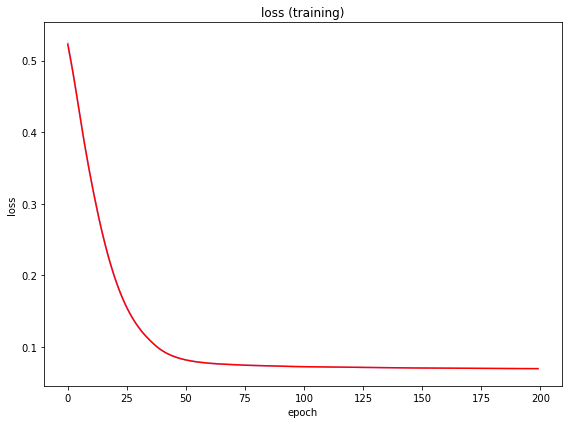


################################################################################
#
# RESULT # 02
#
################################################################################



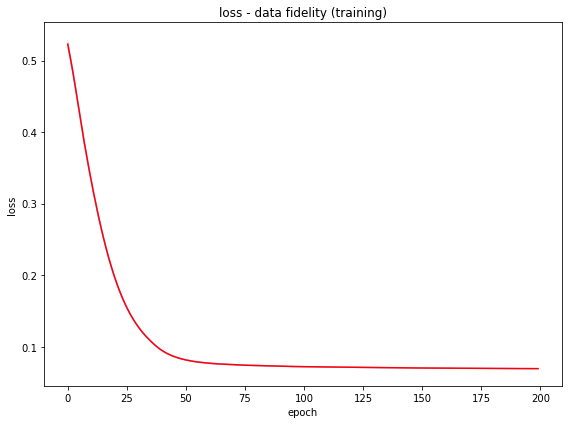


################################################################################
#
# RESULT # 03
#
################################################################################



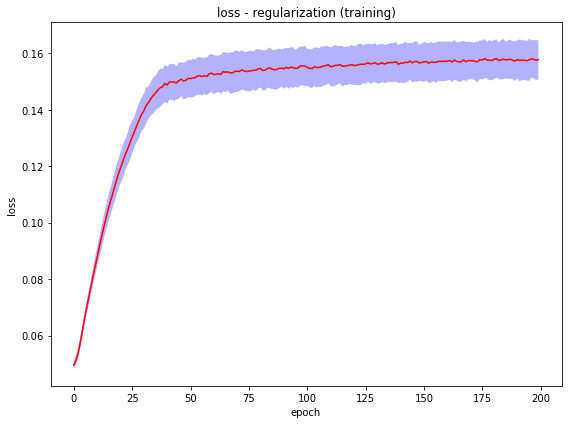


################################################################################
#
# RESULT # 04
#
################################################################################



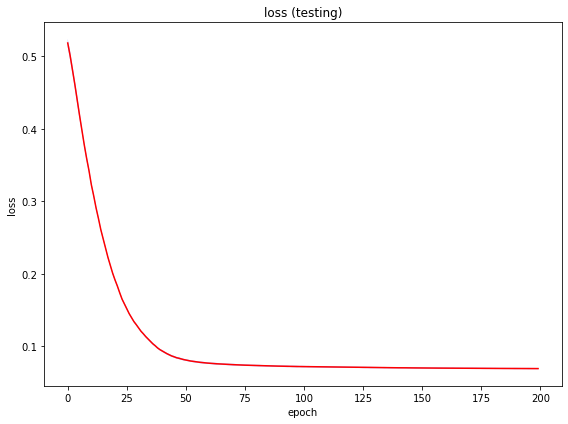


################################################################################
#
# RESULT # 05
#
################################################################################



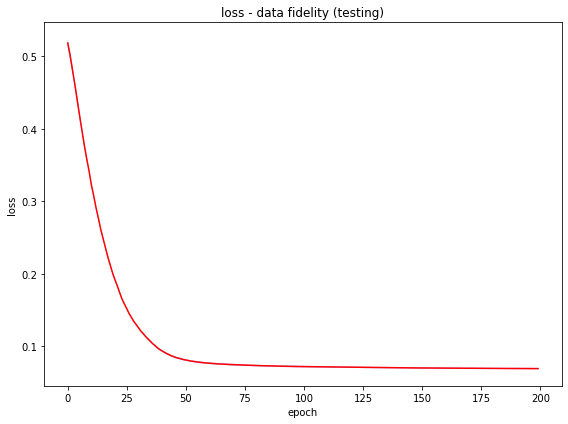


################################################################################
#
# RESULT # 06
#
################################################################################



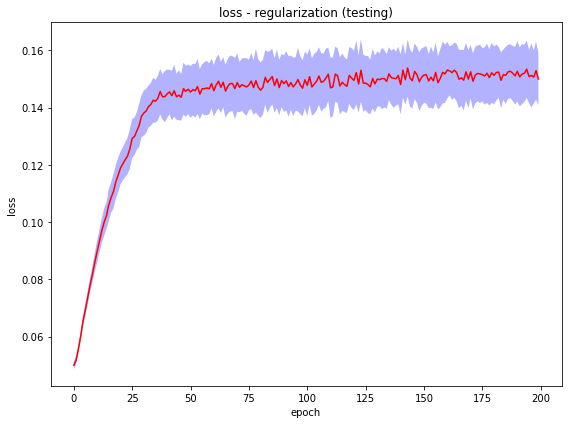


################################################################################
#
# RESULT # 07
#
################################################################################



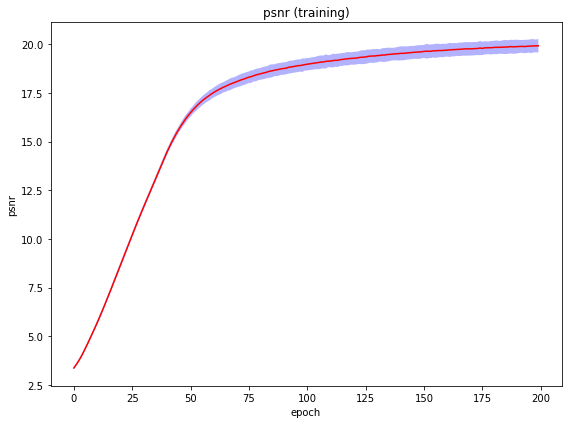


################################################################################
#
# RESULT # 08
#
################################################################################



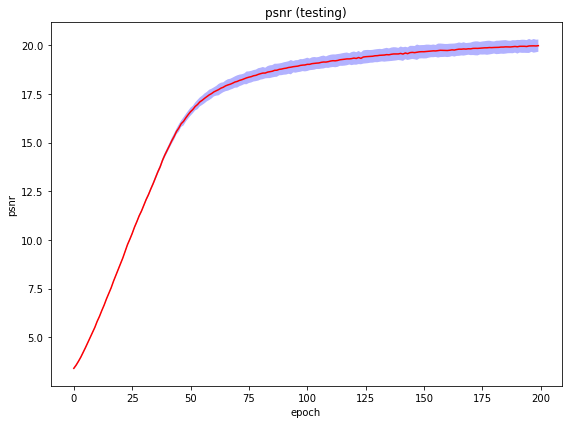


################################################################################
#
# RESULT # 09
#
################################################################################



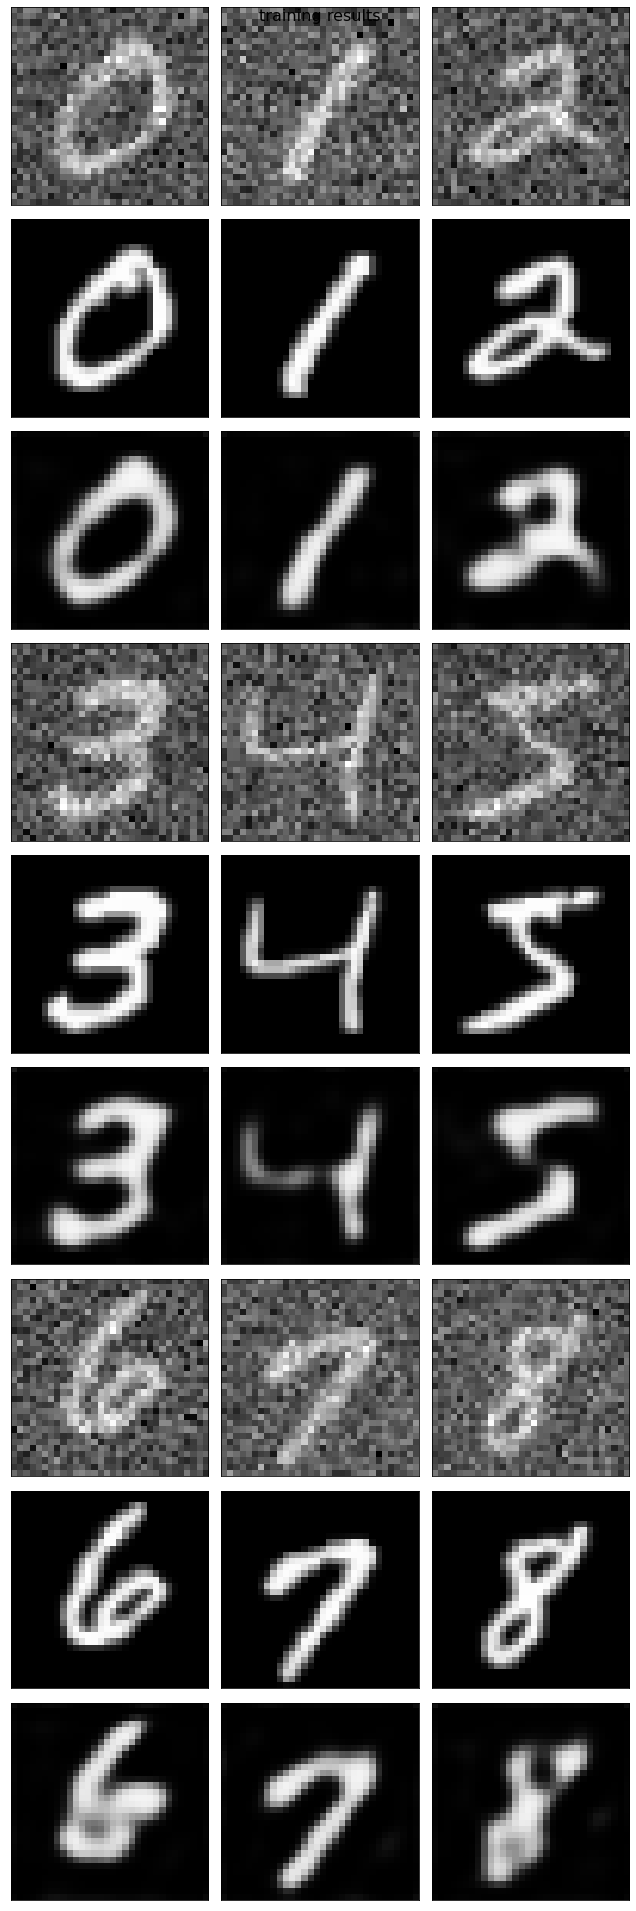


################################################################################
#
# RESULT # 10
#
################################################################################



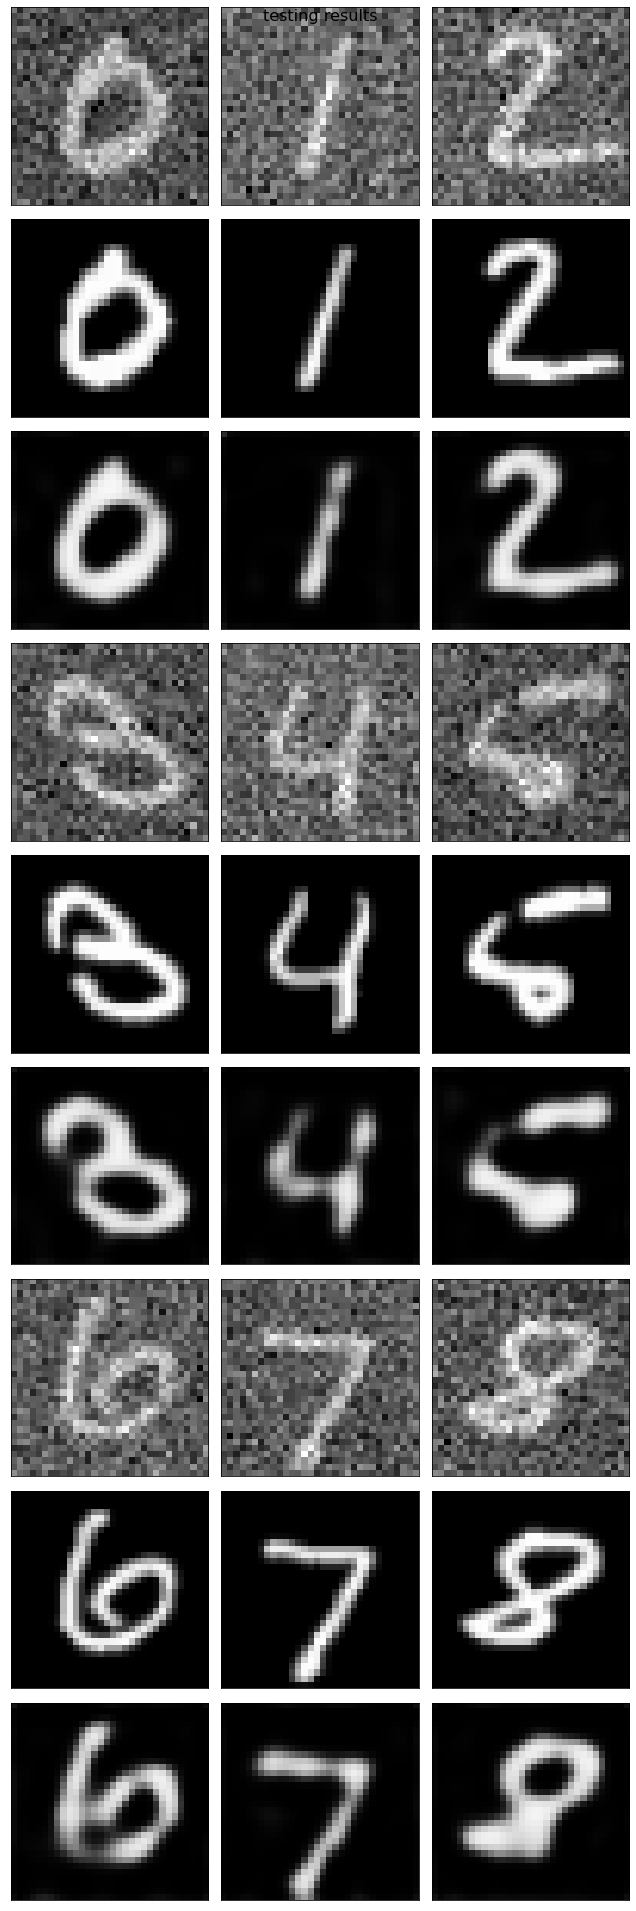


################################################################################
#
# RESULT # 11
#
################################################################################

final training psnr = 19.92502659

################################################################################
#
# RESULT # 12
#
################################################################################

final testing psnr = 19.97912121


In [1726]:
number_result = 12 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)